# Libraries

In [1]:
import pandas as pd
import numpy as np
from cleantext import clean
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets 
import evaluate
import random

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


# Importing the datasets

In [2]:
data_train = pd.read_csv('Datasets/emotion-labels-train.csv')
data_test = pd.read_csv('Datasets/emotion-labels-test.csv')
data_val = pd.read_csv('Datasets/emotion-labels-val.csv')

# Concatenating train and test datasets

In [3]:
data = pd.concat([data_train, data_test], ignore_index=True)
data.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


# Removing emojies and punctuations

In [4]:
data['text_cleaned'] = data['text'].apply(lambda x: clean(x, no_emoji=True))
data['text_cleaned'] = data['text_cleaned'].apply(lambda x: re.sub('@[^\\s]+', '', x))

data.head(20)

,text,label,text_cleaned
0,Just got back from seeing @GaryDelaney in Burs...,joy,just got back from seeing in burslem. amazing...
1,Oh dear an evening of absolute hilarity I don'...,joy,oh dear an evening of absolute hilarity i don'...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,been waiting all week for this game #cheer #fr...
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,": thank you so much, gloria! you're so sweet,..."
4,I feel so blessed to work with the family that...,joy,i feel so blessed to work with the family that...
5,"Today I reached 1000 subscribers on YT!! , #go...",joy,"today i reached 1000 subscribers on yt!! , #go..."
6,"@Singaholic121 Good morning, love! Happy first...",joy,"good morning, love! happy first day of fall. ..."
7,#BridgetJonesBaby is the best thing I've seen ...,joy,#bridgetjonesbaby is the best thing i've seen ...
8,Just got back from seeing @GaryDelaney in Burs...,joy,just got back from seeing in burslem. amazing...
9,@IndyMN I thought the holidays could not get a...,joy,i thought the holidays could not get any more...


# Plotting the label distribution

<Axes: xlabel='label'>

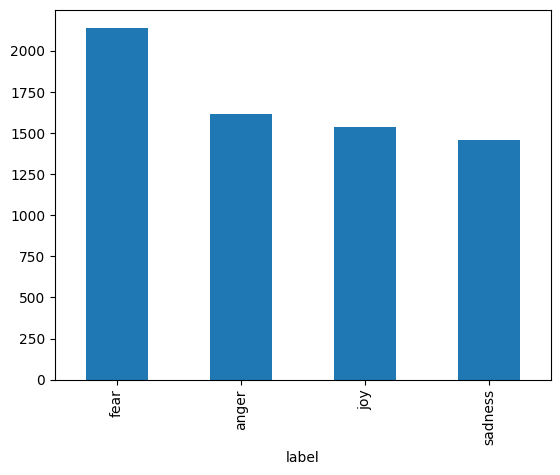

In [5]:
data['label'].value_counts().plot(kind='bar')

# Setting all the labels with same rows

In [6]:
g = data.groupby('label')
data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

C:\Users\1852267\AppData\Local\Temp\ipykernel_17108\2135407547.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))


<Axes: xlabel='label'>

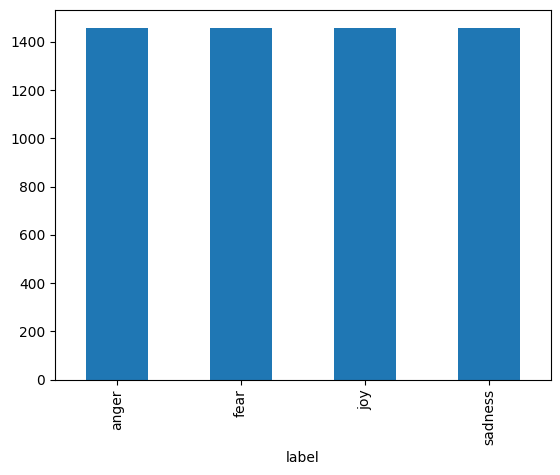

In [7]:
data['label'].value_counts().plot(kind='bar')

# Dataset splitting and Label encoding

In [8]:
# Label encoding
data['label_int'] = LabelEncoder().fit_transform(data['label'])
NUM_LABELS = 4

# Splitting datasets into train, test, and validation sets
train_split, test_split = train_test_split(data, train_size=0.8)
train_split, val_split = train_test_split(train_split, train_size=0.9)
print("Training Dataset Size:", len(train_split))
print("Testing Dataset Size:", len(test_split))
print("Validation Dataset Size:", len(val_split))

# Converting into final datasets
train_df = pd.DataFrame({
    'label': train_split.label_int.values,
    'text' : train_split.text_cleaned.values
})

test_df = pd.DataFrame({
    'label': test_split.label_int.values,
    'text' : test_split.text_cleaned.values
})

train_df = datasets.Dataset.from_dict(train_df)
test_df = datasets.Dataset.from_dict(test_df)

final_dataset = datasets.DatasetDict({
    'train': train_df,
    'test' : test_df
})

print('\n', final_dataset)

Training Dataset Size: 4201
Testing Dataset Size: 1168
Validation Dataset Size: 467

 DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 4201
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1168
    })
})


# Creating embeddings

In [9]:
# XLNet Model
model_name = r'C:\Users\1852267\OneDrive - TCS COM PROD\Desktop\AI Engineer Course\Hugging Face Models\xlnet-base-cased'
# model_name = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(model_name)



# Tokenizer function
def tokenizer_text(example):
    return tokenizer(example['text'], max_length=128, padding='max_length', truncation=True)

# Tokenizer Dataset
tokenizer_dataset = final_dataset.map(tokenizer_text, batched=True)
print(tokenizer_dataset)

# Check all the values of first row
print("\nFirst Text:")
print(tokenizer_dataset['train']['text'][0])
print("\nFirst Text Input ids: ")
print(tokenizer_dataset['train']['input_ids'][0])
print("\nFirst Text Token Type ids: ")
print(tokenizer_dataset['train']['token_type_ids'][0])
print("\nFirst Text Attention Mask: ")
print(tokenizer_dataset['train']['attention_mask'][0])

# Sampling the train and text datasets
small_train_sample = tokenizer_dataset['train'].shuffle(seed=25).select(range(100))
small_eval_sample = tokenizer_dataset['train'].shuffle(seed=25).select(range(100))



Map:   0%|          | 0/4201 [00:00<?, ? examples/s]

Map:   0%|          | 0/1168 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4201
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1168
    })
})

First Text:
 their whole team is limited when they're on the field.

First Text Input ids: 
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 58, 856, 230, 27, 1502, 90, 63, 26, 88, 31, 18, 770, 9, 4, 3]

First Text Token Type ids: 
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

# Fine tuning the model

In [10]:
#  Defining the model
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS, id2label={0: 'anger', 1:'fear', 2:'joy', 3:'sadness'})

# Specify on which stat model gers evaluated
metric = evaluate.load("accuracy")

# compute matric function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)




Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at C:\Users\1852267\OneDrive - TCS COM PROD\Desktop\AI Engineer Course\Hugging Face Models\xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FileNotFoundError: Couldn't find a module script at C:\Users\1852267\OneDrive - TCS COM PROD\Desktop\AI Engineer Course\LLM Section\accuracy\accuracy.py. Module 'accuracy' doesn't exist on the Hugging Face Hub either.